In [1]:
import argparse
import os

from pathlib import Path

import torch
from torch.backends import cudnn

from tqdm import tqdm

from utils.checkpoint import save_checkpoint
from datasets.vessel_set import VesselSet, AneuriskVesselSet
from modules.edm import EDMLoss, EDMPrecond
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import vtk
import numpy as np
from vtk.util import numpy_support  # Ensure this is imported


# Read the .vtp file
reader = vtk.vtkXMLPolyDataReader()
reader.SetFileName("centerlines/0001-network.vtp")
reader.Update()

# Get the polydata object from the reader
polydata = reader.GetOutput()

# Get the points from the polydata
points_vtk_array = polydata.GetPoints().GetData()

if polydata.GetPoints() is not None:
    # Get the points from the polydata
    points_vtk_array = polydata.GetPoints().GetData()

    # Convert VTK array to a NumPy array with shape (NumberOfPoints, 3)
    points = numpy_support.vtk_to_numpy(points_vtk_array)

    print("Extracted points coordinates:", np.array(points).shape)
else:
    print("No points found in the file.")



# Initialize an array to store line IDs for each point
line_ids = np.full(points.shape[0], -1)  # Default to -1 for points without a line assignment

# Assign line IDs to points based on cells (lines)
for line_id in range(polydata.GetNumberOfCells()):
    cell = polydata.GetCell(line_id)  # Each cell is a line with multiple points
    point_ids = cell.GetPointIds()  # Get the point IDs for the current line

    # Assign the current line_id to each point in this line
    for i in range(point_ids.GetNumberOfIds()):
        line_ids[point_ids.GetId(i)] = line_id

# Combine points and line IDs into a single array
points_with_line_ids = np.hstack((points, line_ids.reshape(-1, 1)))

print("Points with line IDs (x, y, z, line_id):")
print(points_with_line_ids)

Extracted points coordinates: (122, 3)
Points with line IDs (x, y, z, line_id):
[[35.7594223  59.80244827 39.67420197  0.        ]
 [35.32811356 58.07311249 40.09186935  0.        ]
 [34.79156113 56.9550209  41.36901855  0.        ]
 [34.68395615 56.3708992  42.30879593  0.        ]
 [35.05499649 55.48483658 43.91479111  0.        ]
 [35.69831085 55.06909943 45.1795578   0.        ]
 [36.41843033 54.86870193 46.18415833  0.        ]
 [37.46755981 54.69267654 47.10786438  0.        ]
 [38.49105453 54.5633812  47.74536133  0.        ]
 [41.77066422 54.42916489 48.98639679  0.        ]
 [43.58059311 54.30939484 49.39413071  0.        ]
 [45.4037056  53.96253586 49.98297882  0.        ]
 [46.64204407 53.48760605 50.24514389  0.        ]
 [48.00107574 52.46397781 50.35545349  0.        ]
 [49.35310364 50.3851738  50.05570602  0.        ]
 [74.02971649 54.54873276 43.89385986  1.        ]
 [73.92865753 53.67111206 44.84450531  1.        ]
 [74.0870285  52.99388504 45.68091965  1.        ]
 [

In [3]:
from extras import serial2centerline
from vtk.util.numpy_support import vtk_to_numpy


    
def vtk_np(filename):
    '''
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()

    # Get the polydata object from the reader
    polydata = reader.GetOutput()'''

    # Get the points from the polydata
    
    polydata = serial2centerline(filename)
   
    points_vtk_array = polydata.GetPoints().GetData()

   
    # Get the points from the polydata
    points_vtk_array = polydata.GetPoints().GetData()

    # Convert VTK array to a NumPy array with shape (NumberOfPoints, 3)
    points = numpy_support.vtk_to_numpy(points_vtk_array)

    #print("Extracted points coordinates:", np.array(points).shape)
    

    # Initialize an array to store line IDs for each point
    line_ids = np.full(points.shape[0], -1)  # Default to -1 for points without a line assignment

    # Assign line IDs to points based on cells (lines)
    for line_id in range(polydata.GetNumberOfCells()):
        cell = polydata.GetCell(line_id)  # Each cell is a line with multiple points
        point_ids = cell.GetPointIds()  # Get the point IDs for the current line

        # Assign the current line_id to each point in this line
        for i in range(point_ids.GetNumberOfIds()):
            line_ids[point_ids.GetId(i)] = line_id

    # Combine points and line IDs into a single array
    

    #print("Points with line IDs (x, y, z, line_id):")
    #print(points_with_line_ids)
    idnum = filename.split("-")[0].split("/")[1]
    point_data = polydata.GetPointData()

    # Extract the "Radius" array (this is the array name as you mentioned)
    radius_array = point_data.GetArray("Radius")

    # Convert the VTK array to a NumPy array
    radius = vtk_to_numpy(radius_array)

    points_with_line_ids = np.hstack((points, line_ids.reshape(-1, 1)))
    points_with_line_ids = np.hstack((points, radius.reshape(-1, 1), line_ids.reshape(-1, 1)))

    return points_with_line_ids


centerline = vtk_np("p10/0001_tree.dat")
print(centerline)

[[0.21523018 0.6418801  0.11636186 0.01436939 1.        ]
 [0.20420203 0.64062589 0.12440679 0.01394511 0.        ]
 [0.19029203 0.643444   0.13396738 0.01438743 0.        ]
 [0.17930685 0.64885491 0.14564595 0.01473854 0.        ]
 [0.16584939 0.66070199 0.16979955 0.01523956 0.        ]
 [0.15974693 0.67089576 0.20086595 0.01576567 0.        ]
 [0.1617564  0.67110741 0.21850763 0.01577726 0.        ]
 [0.16726358 0.66138333 0.24582687 0.01527547 0.        ]
 [0.1767623  0.64425093 0.26525265 0.01431706 0.        ]
 [0.19408049 0.60382175 0.2884858  0.01413606 0.        ]
 [0.23015521 0.65009701 0.10546792 0.01592806 1.        ]
 [0.23640738 0.65903658 0.09847079 0.01612906 1.        ]
 [0.23713338 0.6695658  0.08198185 0.01607494 1.        ]
 [0.23019132 0.68881786 0.07121003 0.0163447  1.        ]
 [0.21253762 0.7066229  0.07209264 0.01594272 1.        ]
 [0.1767709  0.71728808 0.08947619 0.01483514 1.        ]
 [0.16162218 0.72042274 0.1002394  0.01392133 1.        ]
 [0.15239538 0

In [4]:
all_vessels = []
max_segments = 4  # Only keep the first four segments

files = os.listdir("p10")

for file in files:
    
    aneu = vtk_np(os.path.join("p10", file))
    segment_numbers = np.unique(aneu[:, -1]).astype(int)  # Segment numbers (branch numbers) as integers

    # Collect segments for this vessel
    segments = []
    for seg_num in segment_numbers:
        if seg_num >= max_segments:
            #print(f"Warning: Segment number {seg_num} exceeds max_segments ({max_segments - 1}). Skipping this segment.")
            continue  # Skip this segment if it exceeds the max_segments

        # Filter rows for the current segment and remove the segment number column
        segment_points = aneu[aneu[:, -1] == seg_num][:, :-1]

            
        segments.append(segment_points)

    # Keep only the first four segments (or all segments if fewer than 4)
    segments = segments[:max_segments]
        

    # Find the maximum number of points in any segment for this vessel
    max_points = max(segment.shape[0] for segment in segments)

    # If fewer than 4 segments are available, pad with zeros
    while len(segments) < max_segments:
        segments.append(np.zeros((max_points, 4)))  # Assuming each segment has the same number of features

    # Pad each segment to have the same number of points
    padded_segments = [
        np.pad(segment, ((0, max_points - segment.shape[0]), (0, 0)), 'constant')
        for segment in segments
    ]
        
        
    # Stack all segments for this vessel along a new dimension (axis 0)
    vessel_data = np.stack([padded_segments], axis=0)

    # Add the stacked segments for this vessel to the list of all vessels
    all_vessels.append(vessel_data)

# Determine the maximum points across all vessels

max_points = max(arr.shape[2] for arr in all_vessels)
# Pad each array to have the shape (max_segments, max_points, 16)
padded_arrays = []
for arr in all_vessels:
    # Calculate padding for the points dimension
    pad_points = max_points - arr.shape[2]
    # Pad the array
    padded_arr = np.pad(
        arr,
        pad_width=((0, 0), (0, 0), (0, pad_points), (0, 0)),
        mode='constant',
        constant_values=0  # Padding value can be adjusted if necessary
    )
    padded_arrays.append(padded_arr)
    


# Stack the padded arrays along a new dimension
final_data = np.stack(padded_arrays, axis=0)
print(final_data.shape)
final_data = final_data.reshape(102,4,-1,4)
print("Final data shape:", final_data.shape)  # Expected shape: (num_vessels, max_segments, max_points, 16)

train = final_data[:90,:,:,:]
test =  final_data[90:,:,:,:]
np.save("datasets/aneurisk/data_train.npy", train)
np.save("datasets/aneurisk/data_test.npy", test)

(102, 1, 4, 10, 4)
Final data shape: (102, 4, 10, 4)


In [5]:
final_data[0].shape

(4, 10, 4)

In [14]:
final_data[0][3]

array([[0.2599251 , 0.57034707, 0.37703413, 0.0228822 ],
       [0.29175544, 0.5906781 , 0.38474134, 0.02004315],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
tree = final_data[2]
valid_segments = []
for segment in tree:
    # Remove rows with all zeros (padded points)
    valid_points = segment[np.any(segment != 0, axis=-1)]
    if valid_points.shape[0] > 1:  # Include segment only if it has valid points
        valid_segments.append(valid_points)

valid_segments

[array([[0.51451129, 0.52388507, 0.19152611, 0.01404405],
        [0.50689149, 0.51614273, 0.18245612, 0.01377201],
        [0.49614596, 0.50529432, 0.17528535, 0.01382766],
        [0.48486161, 0.48973137, 0.17107539, 0.01444589],
        [0.47625542, 0.47808605, 0.17497836, 0.01475709],
        [0.46839222, 0.46746308, 0.18206584, 0.0148348 ],
        [0.46046865, 0.45785418, 0.19415694, 0.01554891],
        [0.45627171, 0.45188046, 0.20945211, 0.01616972],
        [0.45739529, 0.44604069, 0.24675266, 0.0168912 ]]),
 array([[0.52276635, 0.54021227, 0.21242917, 0.01418817],
        [0.52275825, 0.55480695, 0.24938516, 0.01367322],
        [0.51001054, 0.56699109, 0.27780026, 0.01403212],
        [0.48840854, 0.58013719, 0.30500039, 0.01413511],
        [0.46632802, 0.60413325, 0.31927326, 0.01316287],
        [0.45171058, 0.62588227, 0.32846573, 0.01326887]]),
 array([[0.46179962, 0.67098552, 0.32752836, 0.01091611],
        [0.48143545, 0.68469501, 0.32818484, 0.01028895],
        [0

In [62]:
points_per_segment = [len(segment) for segment in valid_segments]
total_points = sum(points_per_segment)
print(points_per_segment)
# Sample points per segment based on the required total number of points
sample_points_per_segment = [
            int((n / total_points) * 128) for n in points_per_segment
        ]
print(sample_points_per_segment)
sample_points_per_segment[np.argmax(sample_points_per_segment)] += (
            128 - sum(sample_points_per_segment)
        )
print(sum(sample_points_per_segment))


[9, 6, 3, 4]
[52, 34, 17, 23]
128


In [65]:
# Interpolate points for equidistant sampling
uniform_tree = []

        
# interpolate points for equidistant sampling
for segment, num_sample_points in zip(valid_segments, sample_points_per_segment):
    segment_rows = []

    dists = np.array(
        [0, *np.linalg.norm(segment[:-1, :3] - segment[1:, :3], axis=-1)]
    )
    print(dists)
    s = np.cumsum(dists)

    points = np.linspace(0, s[-1], num_sample_points)

    for row in segment.T:
        segment_rows.append(np.interp(points, s, row))

    uniform_tree.append(np.vstack(segment_rows).T)

# get one-hot labels
typed_tree = []
num_types = 4 
for vessel_type, segment in enumerate(uniform_tree):
    
    one_hot = (
        np.zeros((segment.shape[0], 1)) + vessel_type - np.arange(num_types)
    )
    one_hot = (one_hot == 0).astype(float)

    typed_tree.append(np.concatenate((segment, one_hot), axis=-1))

tree = torch.from_numpy(np.concatenate(typed_tree, axis=0))



[0.         0.01415168 0.01686932 0.01967907 0.01499711 0.014997
 0.01735824 0.01694821 0.03777164]
[0.         0.03973349 0.03344212 0.03713911 0.03559599 0.02777032]
[0.         0.02395718 0.02754947]
[0.         0.02919363 0.02215662 0.02091614]


t torch.Size([128, 8])
torch.Size([128, 3])


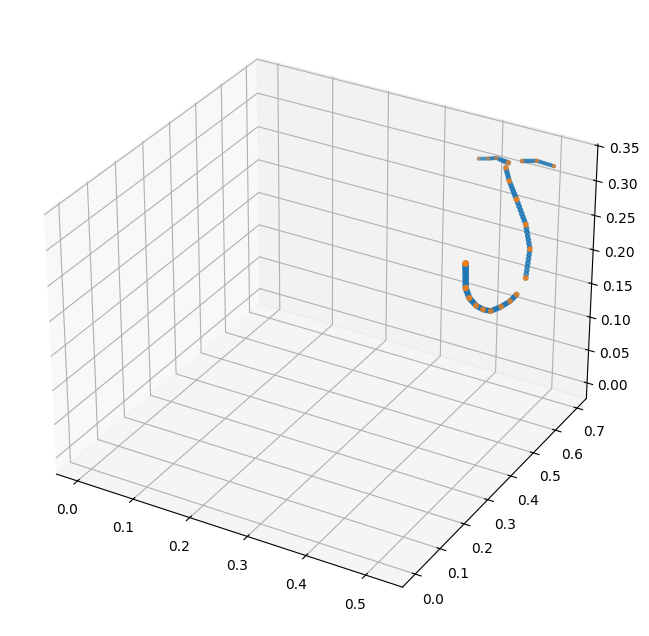

In [64]:
print("t", tree.shape)
points, radii, types = tree[:, :3], tree[:, 3], tree[:, 4:]
print(points.shape)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")
#ax.scatter(*points.T, s=(220 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
ax.scatter(*points.T, s=(220 * radii)**2)
#ax.scatter(0, 0, 0, color='red', s=50, label="Origin")
tree2 = final_data[2].reshape(1,-1,4)
points, radii, types = tree2[:, :, :3], tree2[:, :, 3], tree2[:, :, 4:]
ax.scatter(*points.T, s=(220 * radii) ** 2)


torch.Size([1, 128, 3])


/tmp/ipykernel_1643830/99746520.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115564/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  ax.scatter(*points.T, s=(10000 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)


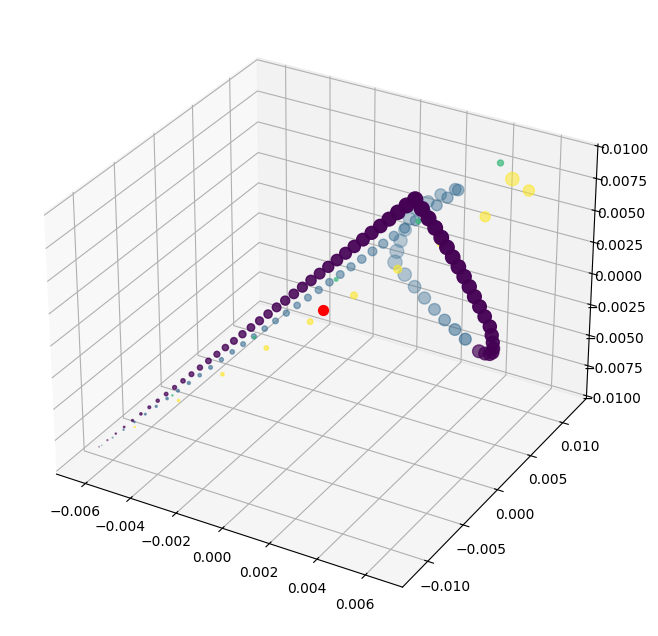

torch.Size([1, 128, 3])


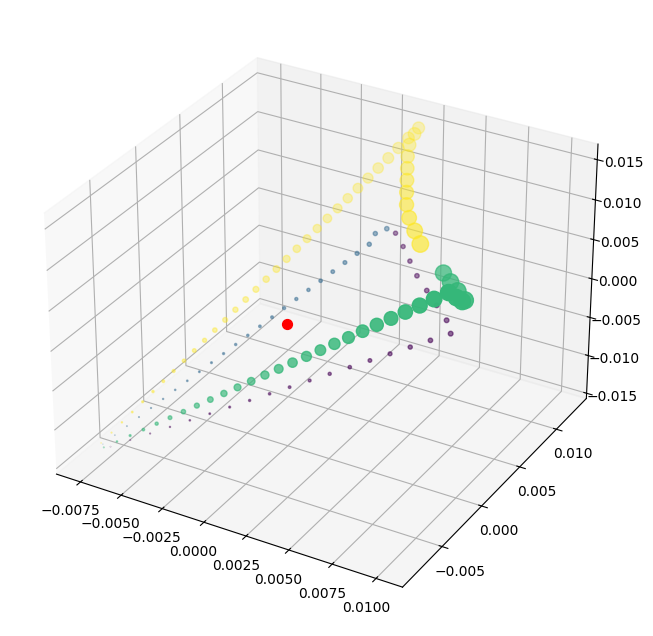

torch.Size([1, 128, 3])


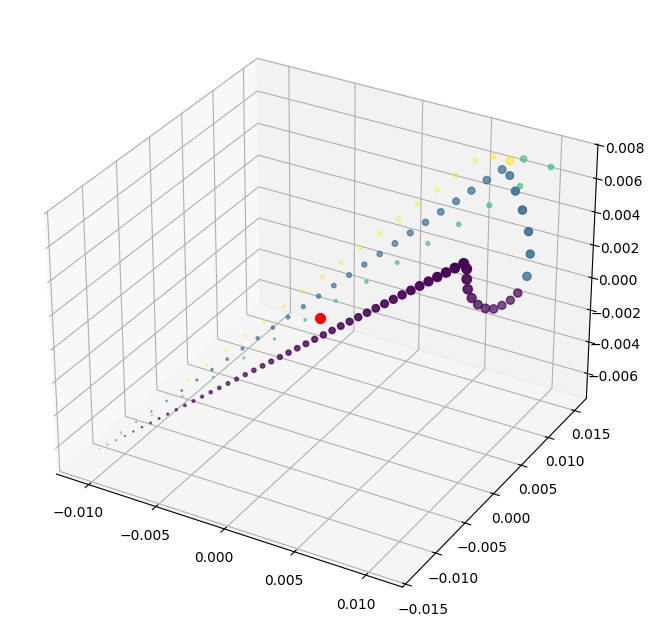

torch.Size([1, 128, 3])


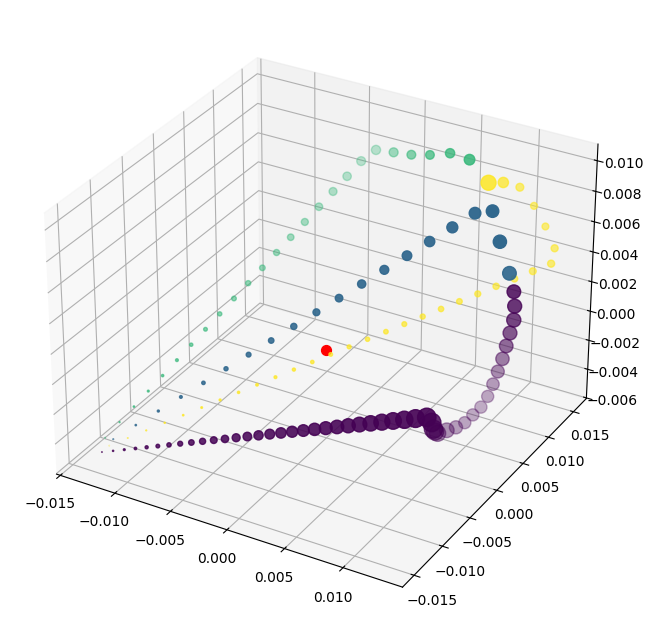

torch.Size([1, 128, 3])


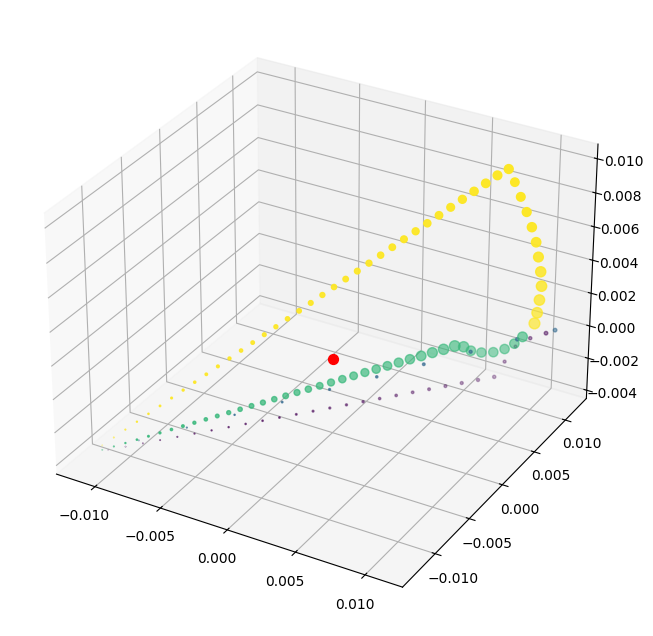

torch.Size([1, 128, 3])


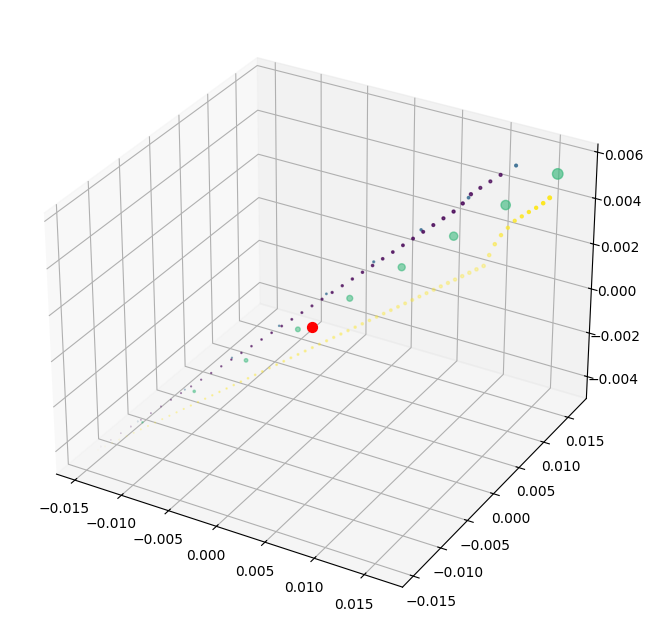

In [6]:
train_set = AneuriskVesselSet(split="train", path="aneurisk")

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

for i, (inputs, labels) in enumerate(train_loader):
    

    points, radii, types = inputs[:, :, :3], inputs[:, :, 3], inputs[:, :, 4:]
    print(points.shape)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection="3d")
    #ax.scatter(*points.T, s=(220 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(*points.T, s=(10000 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(0, 0, 0, color='red', s=50, label="Origin")
    
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    #ax.set_zlim(-1, 1)

    plt.show()
    if i > 4:
        break

keep trees with a maximum of 4 branches and depth 10. for this I need to find the optimal root of the tree. the problem is the segments in the structure generated are not contiguous so if I choose the first four I end up with separated segments and not a vessel structure

In [7]:
a = np.load("centerlineArray/centerlines1.npy")